## L'importation des modeles necessaire

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
import os
warnings.filterwarnings("ignore")

## Telechargement de dataset

In [2]:
paths =[]
labels = []
for dirname, _ , filenames in os.walk('./data'):
    for file in filenames:
        paths.append(os.path.join(dirname, file))
        label = file.split('_')[-1]
        label = label.split('.')[0]
        labels.append(label.lower())
       


#Data frame

In [3]:
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()


,speech,label
0,./data\OAF_angry\OAF_back_angry.wav,angry
1,./data\OAF_angry\OAF_bar_angry.wav,angry
2,./data\OAF_angry\OAF_base_angry.wav,angry
3,./data\OAF_angry\OAF_bath_angry.wav,angry
4,./data\OAF_angry\OAF_bean_angry.wav,angry


In [4]:
df['label'].value_counts()

label
angry      800
disgust    800
fear       800
happy      800
neutral    800
ps         800
sad        800
Name: count, dtype: int64

##EDA

<Axes: xlabel='count', ylabel='label'>

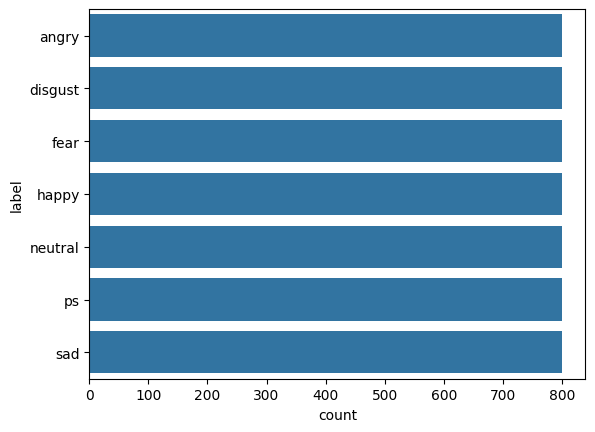

In [5]:
sns.countplot(df['label'])

In [6]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

./data\OAF_Fear\OAF_back_fear.wav


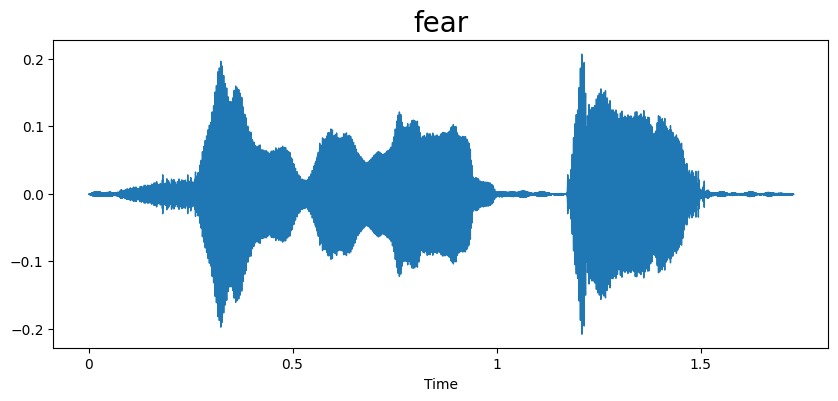

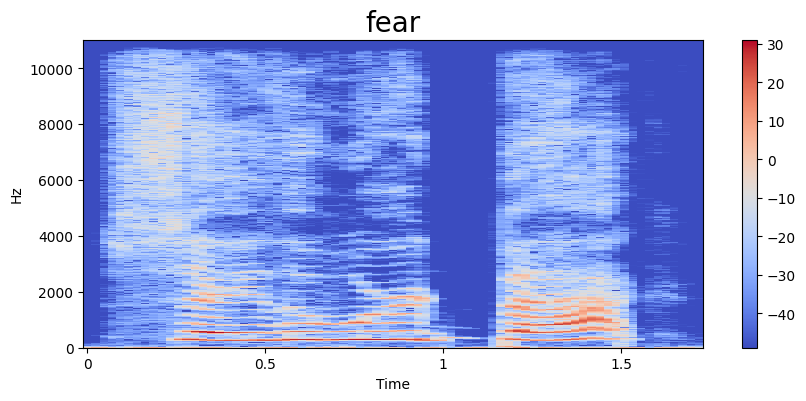

In [7]:
emotion = 'fear'
filtered_df = df[df['label'] == emotion]
if not filtered_df.empty:
    path = filtered_df['speech'].iloc[0] 
    print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

./data\OAF_Pleasant_surprise\OAF_back_ps.wav


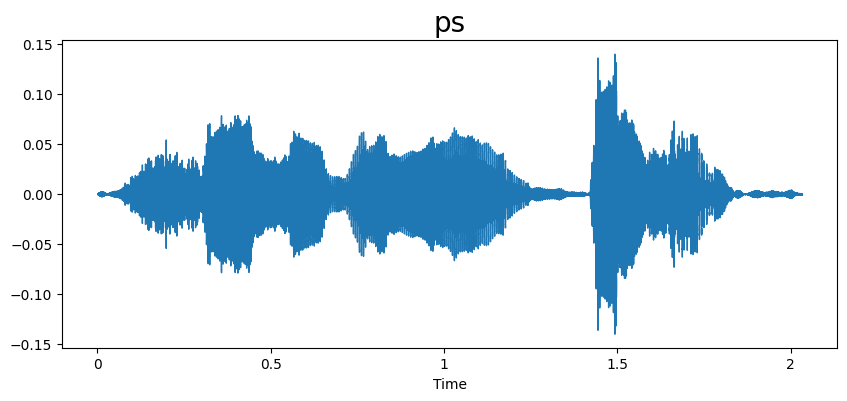

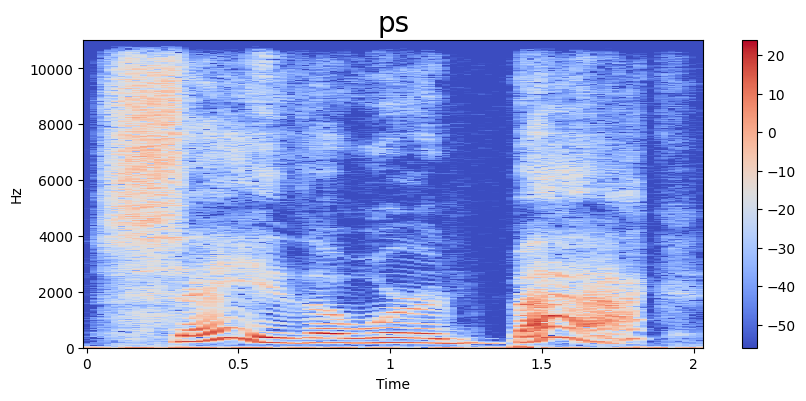

In [8]:
emotion = 'ps'
path =np.array(df['speech'][df['label'] == emotion])[0]
print(path)
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

## feature extraction


In [9]:
def extraction_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis= 0)
    return mfcc

In [10]:
extraction_mfcc(df['speech'][0])

array([-3.96986206e+02,  7.74405365e+01, -1.95927906e+01, -2.16666889e+01,
       -2.11275601e+00,  1.00753632e+01, -2.03667068e+01, -6.09244919e+00,
       -7.21228313e+00, -5.57366073e-01, -1.83255327e+00,  2.02101365e-01,
        7.27551103e-01,  1.31773746e+00,  2.88633752e+00,  2.85579085e+00,
       -4.71292162e+00, -4.43651056e+00, -1.62115920e+00, -1.02398405e+01,
       -7.55126286e+00, -1.79688025e+00, -7.03765249e+00,  9.43658352e+00,
        8.35585499e+00,  2.17123604e+01,  1.92169914e+01,  2.03489304e+01,
        1.34133663e+01,  8.33917141e+00,  3.94722193e-01,  5.11131477e+00,
        9.56873894e+00,  5.45486832e+00,  2.50996351e+00, -1.82390726e+00,
        4.86896181e+00,  9.31392384e+00,  2.08914995e+00, -1.90649164e+00],
      dtype=float32)

In [11]:
X_mfcc = df['speech'].apply(lambda x: extraction_mfcc(x))

In [12]:
X_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.6560082, -32.74544, -...
2       [-429.79196, 46.124, 1.5550474, -0.21709426, 2...
3       [-403.46118, 76.32369, -12.531775, -22.288858,...
4       [-434.05756, 77.4455, 10.8654995, 16.092945, 8...
                              ...                        
5595    [-406.48053, 80.379875, 32.462395, 46.579094, ...
5596    [-426.90918, 102.54756, 24.800041, 43.048096, ...
5597    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
5598    [-434.8618, 89.906364, 28.373262, 39.57707, -2...
5599    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: speech, Length: 5600, dtype: object

In [13]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(5600, 40)

In [14]:
#input splite
X = np.expand_dims(X, -1)
X.shape

(5600, 40, 1)

In [15]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [16]:
y = y.toarray()


In [17]:
y.shape

(5600, 7)

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)



print(f"Shape of X_train : {X_train.shape}")
print(f"Shape of X_test : {X_test.shape}")
print(f"Shape of y_train : {y_train.shape}")
print(f"Shape of y_test : {y_test.shape}")

Shape of X_train : (4480, 40, 1)
Shape of X_test : (1120, 40, 1)
Shape of y_train : (4480, 7)
Shape of y_test : (1120, 7)


## Create LSTM Model 

In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras import metrics

model = Sequential([
    LSTM(123, return_sequences=False, input_shape=(40,1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax')
])

#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', metrics.Precision(), metrics.Recall()])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 123)            │        61,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,747 (280.26 KB)

 Trainable params: 71,747 (280.26 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
#train the model 
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=512, shuffle=True)

Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 400ms/step - accuracy: 0.2085 - loss: 1.8969 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.5295 - val_loss: 1.6057 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 238ms/step - accuracy: 0.4485 - loss: 1.5838 - precision: 0.7556 - recall: 0.0145 - val_accuracy: 0.6580 - val_loss: 1.1968 - val_precision: 0.9952 - val_recall: 0.1857
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - accuracy: 0.5657 - loss: 1.2356 - precision: 0.8409 - recall: 0.2171 - val_accuracy: 0.7223 - val_loss: 0.8132 - val_precision: 0.9419 - val_recall: 0.4196
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.6442 - loss: 0.9091 - precision: 0.8114 - recall: 0.4423 - val_accuracy: 0.7884 - val_loss: 0.6010 - val_precision: 0.9359 - val_recall: 0.5473
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step - accuracy: 0.7209 - loss: 0.7126 - precision: 0.8219 - recall: 0.5738 - val_accuracy: 0.8696 - v

## Result

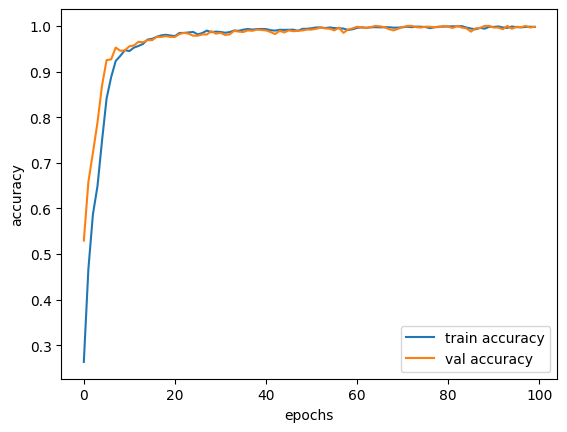

In [21]:
epochs = list(range(100))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, label='train accuracy')
plt.plot(epochs, val_acc, label='val accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

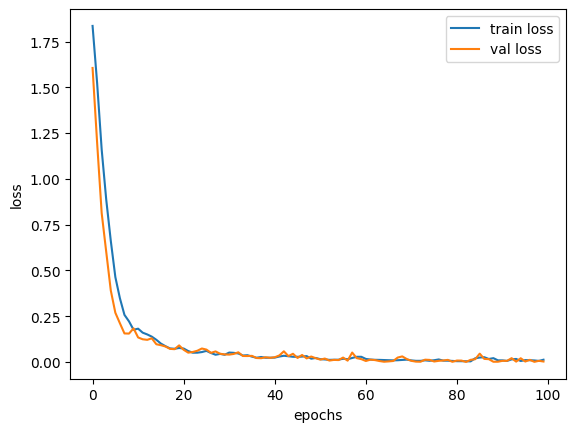

In [22]:
epochs = list(range(100))
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")


35/35 - 1s - 18ms/step - accuracy: 0.9982 - loss: 0.0027 - precision: 0.9982 - recall: 0.9982
Test Loss: 0.0027, Test Accuracy: 0.9982
Test Precision: 0.9982
Test Recall: 0.9982


## Confusion Matrix 


In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score


# Get model predictions on the test set
# Evaluate Model
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f'Model Accuracy: {accuracy * 100:.2f}%')

# Compute Precision, Recall, F1-Score
print("Classification Report:\n", classification_report(y_true_labels, y_pred_labels, digits=4))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Model Accuracy: 99.82%
Classification Report:
               precision    recall  f1-score   support

           0     0.9888    1.0000    0.9944       176
           1     1.0000    1.0000    1.0000       153
           2     1.0000    0.9866    0.9932       149
           3     1.0000    1.0000    1.0000       143
           4     1.0000    1.0000    1.0000       175
           5     1.0000    1.0000    1.0000       165
           6     1.0000    1.0000    1.0000       159

    accuracy                         0.9982      1120
   macro avg     0.9984    0.9981    0.9982      1120
weighted avg     0.9982    0.9982    0.9982      1120



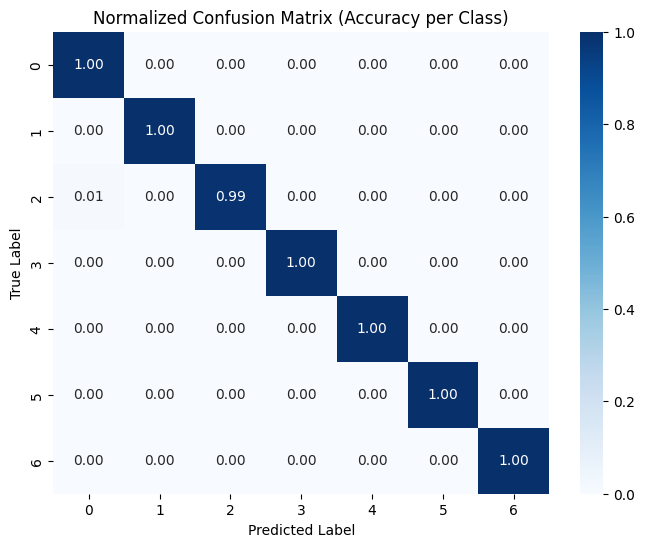

In [25]:

# Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

# Normalize Confusion Matrix (Row-wise Normalization)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix with Accuracy
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Normalized Confusion Matrix (Accuracy per Class)")
plt.show()


In [26]:
model.save("model.h5")